In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## News Data Treatment

Source: https://newsdata.io/datasets

#### Setup

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from src.plots import (plot_bars, plot_subplots,
                       plot_wordclouds_by_language,
                       plot_bubble_by_categories,
                       plot_heatmap_by_categories)
from src.cleaning_text import (which_language,
                               clean_text,
                               get_stopwords)
from src.config import language_dict
from tqdm import tqdm
import re
tqdm.pandas()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/carycccs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Data Access

In [ ]:
datasets = []

directory_path = '.'
folders = [name for name in os.listdir(directory_path) if \
           os.path.isdir(os.path.join(directory_path, name))]
for folder in folders:
    df = pd.read_csv(f"raw_dataframes/{folder}/{folder}.csv")
    df['Category'] = folder.split('_')[0]
    datasets.append(df)
dataframe = pd.concat(datasets)

In [4]:
len(dataframe)

151654

#### Exploratory Data Analysis

In [5]:
dataframe[['title', 'link', 'keywords', 'creator', 'video_url', 'description', 'Category']].head(2)

,title,link,keywords,creator,video_url,description,Category
0,เช็คที่นี่! 10 จว.ติดโควิดสูงสุด ผู้ป่วย'ปัตตา...,https://www.naewna.com/local/611436,NaN,NaN,NaN,เมื่อวันที่ 26 ตุลาคม 2564ศูนย์ข้อมูล COVID-19...,Covid
1,EMA: dawka przypominająca Moderny może być pod...,"https://wyborcza.pl/7,75399,27731864,ema-dawka...",NaN,['Jakub Wencel'],NaN,"Europejska Agencja Leków (EMA) poinformowała, ...",Covid


In [6]:
dataframe[['content', 'pubDate', 'full_description', 'image_url', 'source_id']].sample(2)

,content,pubDate,full_description,image_url,source_id
2777,NaN,2021-10-25 03:07:50,"Este domingo, 491 pacientes se recuperaron de ...",NaN,lostiempos
4388,NaN,2021-10-25 12:27:00,"Dallas, Texas, United states, Oct. 25, 2021 (G...",NaN,globenewswire


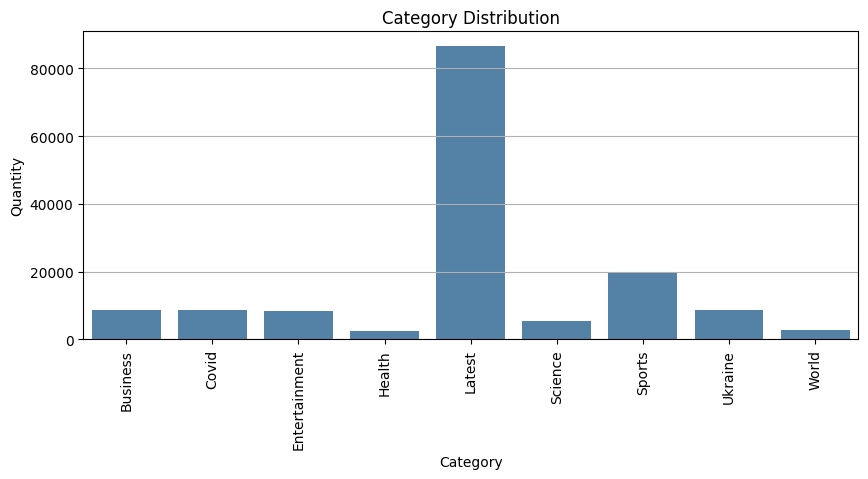

In [7]:
grouped_df = dataframe.groupby(['Category'])['Category'].count().to_frame()\
    .rename(columns={'Category': 'Quantity'}).reset_index()
plot_bars(grouped_df, 'Category', 'Quantity')

#### Null treatment

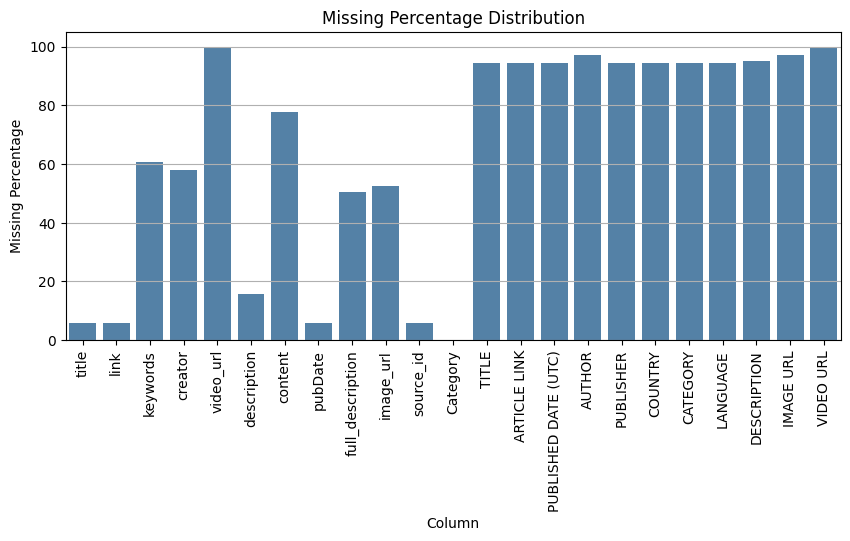

In [8]:
missing_percentages = dataframe.isnull().mean() * 100
missing_percentages_df = missing_percentages.reset_index()
missing_percentages_df.columns = ['Column', 'Missing Percentage']
missing_percentages_df['Missing Percentage'] = missing_percentages_df['Missing Percentage'].apply(lambda x: np.round(x,1))
plot_bars(missing_percentages_df, 'Column', 'Missing Percentage', title='Missing Percentage')

In [9]:
missing_percentages_df.describe()

,Missing Percentage
count,23.000000
mean,64.656522
std,38.590364
min,0.000000
25%,33.000000
50%,94.300000
75%,94.350000
max,100.000000


In [10]:
percentile_value = float(np.round(missing_percentages_df['Missing Percentage'].describe()['mean'], 2))
percentile_value

64.66

In [11]:
columns_to_remove = missing_percentages_df[missing_percentages_df['Missing Percentage']>percentile_value]['Column'].values
print('Columns to remove = ', columns_to_remove)

Columns to remove =  ['video_url' 'content' 'TITLE' 'ARTICLE LINK' 'PUBLISHED DATE (UTC)'
 'AUTHOR' 'PUBLISHER' 'COUNTRY' 'CATEGORY' 'LANGUAGE' 'DESCRIPTION'
 'IMAGE URL' 'VIDEO URL']


In [12]:
dataframe.drop(columns=columns_to_remove, inplace=True, axis=0)

In [13]:
dataframe.isna().sum()

title                8681
link                 8678
keywords            91913
creator             87915
description         23531
pubDate              8678
full_description    76638
image_url           79581
source_id            8678
Category                0
dtype: int64

In [14]:
dataframe = dataframe.dropna(axis=0)
dataframe.isna().sum()

title               0
link                0
keywords            0
creator             0
description         0
pubDate             0
full_description    0
image_url           0
source_id           0
Category            0
dtype: int64

### Explratory Data Analysis after Null Treatment

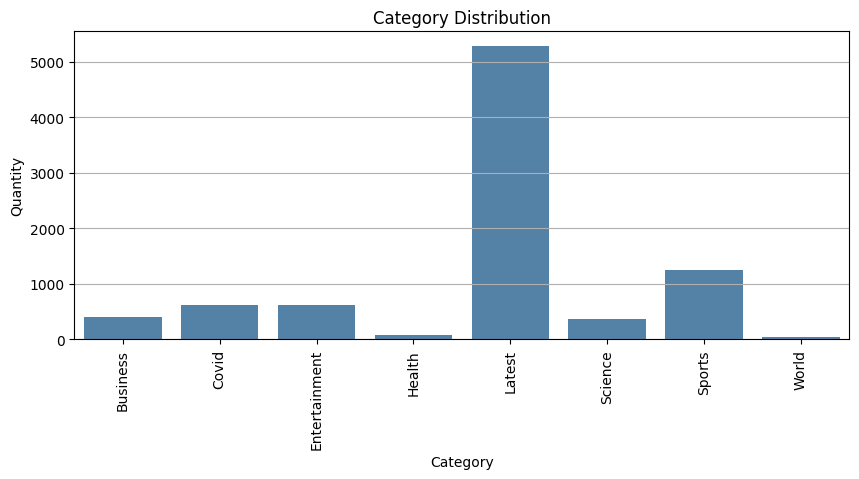

In [15]:
grouped_df = dataframe.groupby(['Category'])['Category'].count().to_frame()\
    .rename(columns={'Category': 'Quantity'}).reset_index()

plot_bars(grouped_df, 'Category', 'Quantity')

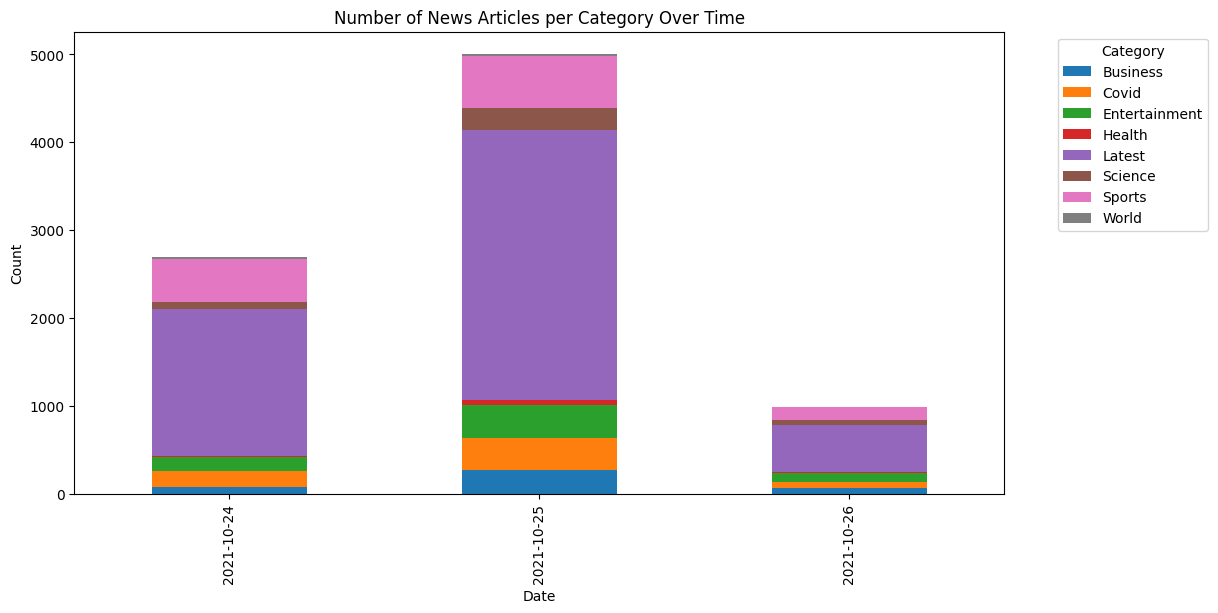

In [16]:
dataframe['date'] = pd.to_datetime(dataframe['pubDate'])
dataframe['date'] = dataframe['date'].dt.to_period('D')
df_grouped = dataframe.groupby(['date', 'Category']).size().unstack().fillna(0)
df_grouped.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Number of News Articles per Category Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

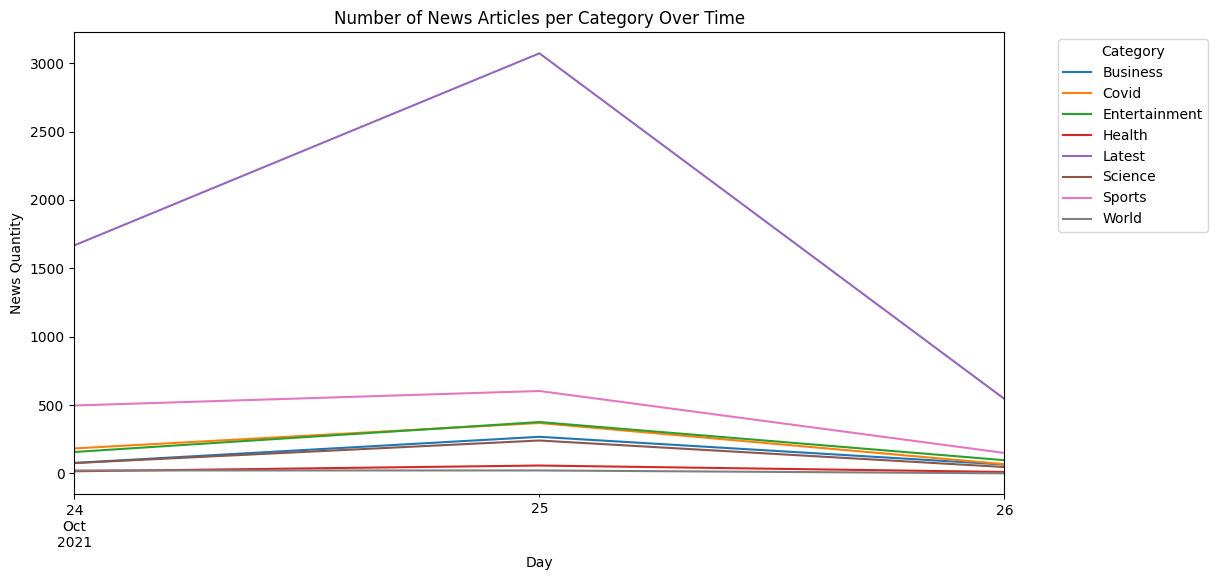

In [17]:
df_grouped.plot(kind='line', figsize=(12, 6))
plt.title('Number of News Articles per Category Over Time')
plt.xlabel('Day')
plt.ylabel('News Quantity')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [18]:
dataframe['len_description'] = dataframe['description'].apply(lambda x: len(x.split(' ')))
mean_lengths = dataframe.groupby('Category')['len_description'].mean().reset_index()
mean_lengths.columns = ['Category', 'Mean Length Words']
mean_lengths['Mean Length Words'] = mean_lengths['Mean Length Words'].apply(lambda x: np.round(x, 2))

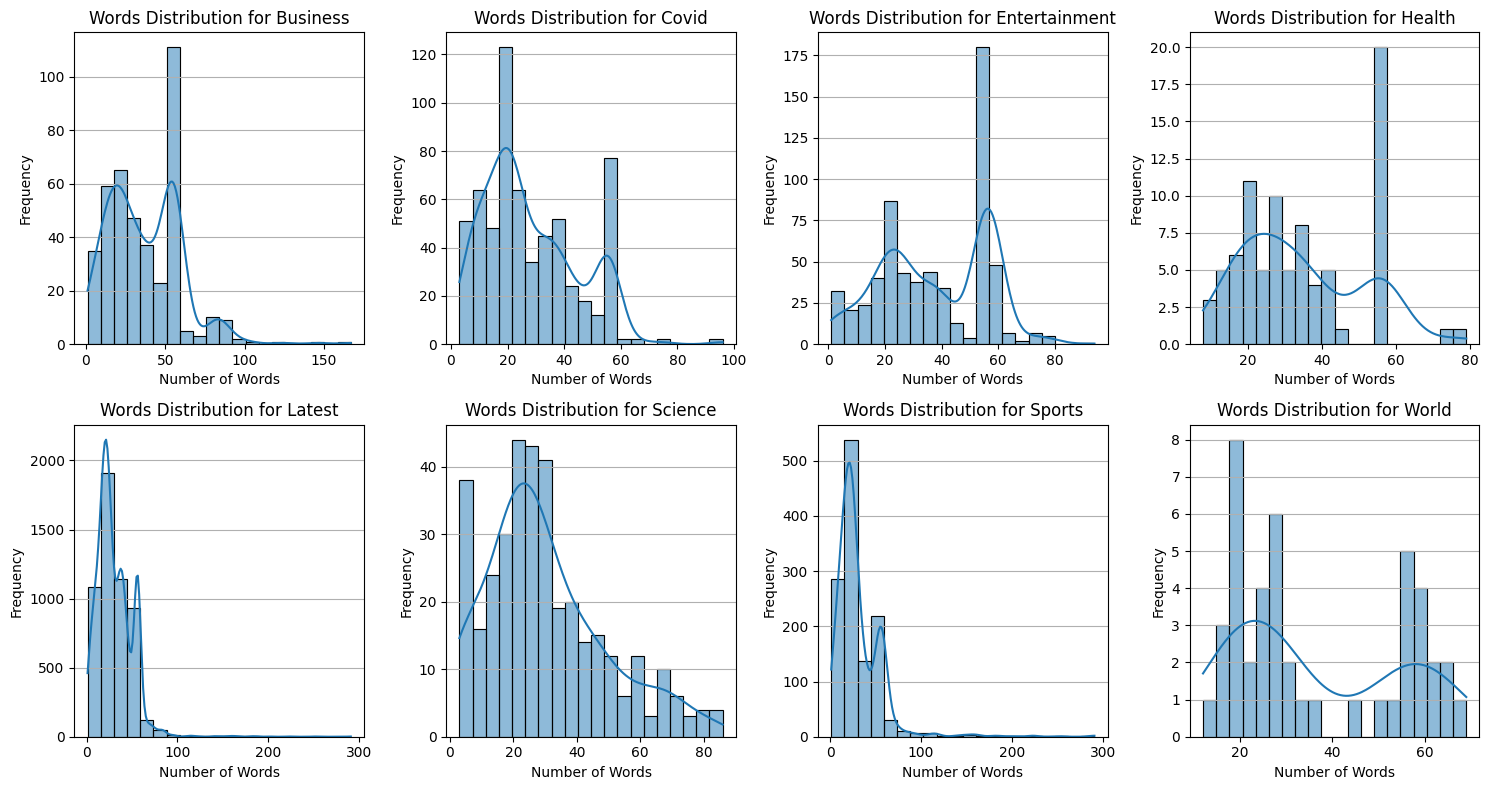

In [19]:
categories = mean_lengths['Category'].unique()
nrows = 2
ncols = 4
plot_subplots(dataframe, nrows, ncols, categories)

#### Language Detector

In [ ]:
dataframe['language_sample'] = dataframe['description'].apply(lambda x: " ".join(x.split(' ')[0:200]))
dataframe['language'] = dataframe['language_sample'].progress_apply(which_language)
dataframe['language'] = dataframe['language'].apply(lambda x: x['language'])
dataframe = dataframe[dataframe['language'] != 'UNKNOWN'].copy()

In [24]:
language_df = dataframe.groupby(['language'])['language'].count().to_frame().rename(columns={'language': 'quantity'}).reset_index()
language_df = language_df[language_df['quantity'] > 10].copy()
valid_languages = language_df['language'].unique()
dataframe = dataframe[dataframe['language'].isin(valid_languages)].copy()

In [25]:
print(valid_languages)

['de' 'en' 'es' 'fr' 'hu' 'it' 'ja' 'ko' 'lv' 'nl' 'no' 'pt' 'ru' 'sk'
 'sl' 'zh-tw']


In [26]:
dataframe['language_name'] = dataframe['language'].apply(lambda x: language_dict[x])

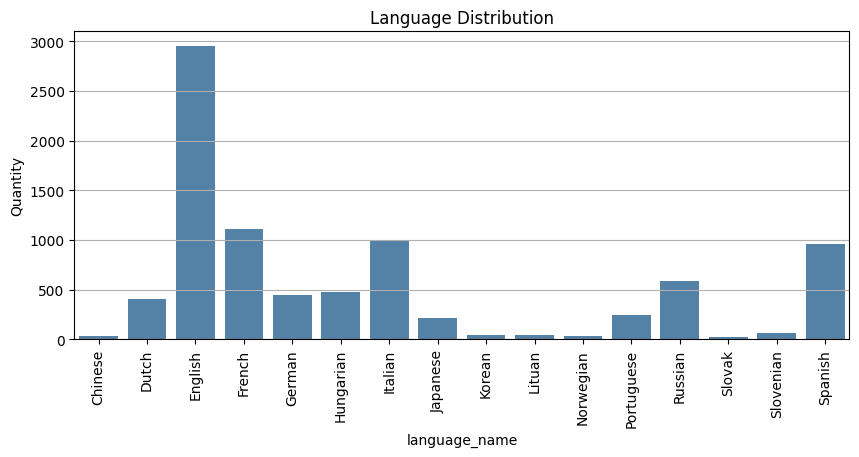

In [27]:
grouped_df = dataframe.groupby(['language_name'])['Category'].count().to_frame()\
    .rename(columns={'language_name': 'Language', 'Category': 'Quantity'}).reset_index()
plot_bars(grouped_df, 'language_name', 'Quantity', 'Language')

In [28]:
most_common_language = list(grouped_df.sort_values(by='Quantity', ascending=False).head(5).to_dict()['language_name'].values())

In [29]:
dataframe = dataframe[dataframe['language_name'].isin(most_common_language)].copy()

In [30]:
dataframe['language_name'].value_counts()

language_name
English    2953
French     1114
Italian    1004
Spanish     961
Russian     588
Name: count, dtype: int64

#### WordClouds by Idiom and Category

In [31]:
grouped_df = dataframe.groupby(['language_name', 'Category'])['Category'].count().to_frame()\
    .rename(columns={'language_name': 'Language', 'Category': 'Quantity'}).reset_index()
grouped_df = grouped_df.sort_values(by='Category')
grouped_df = grouped_df[grouped_df['Category'] == 'Covid'].copy()

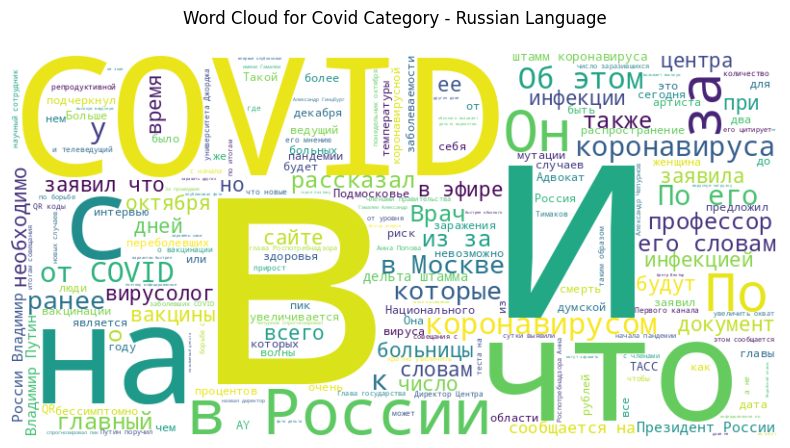

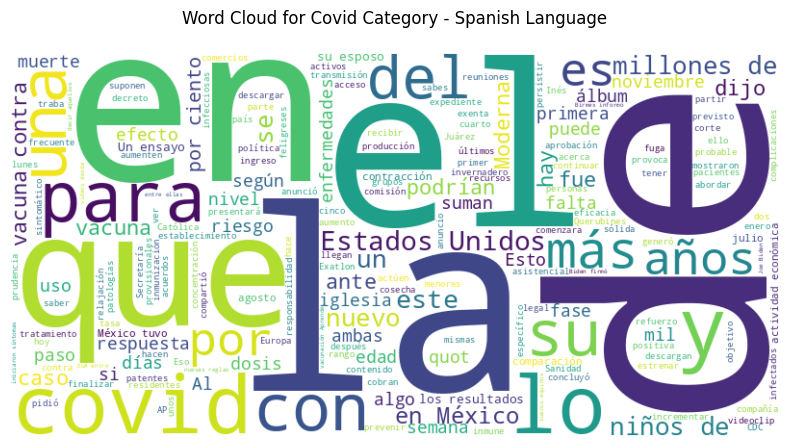

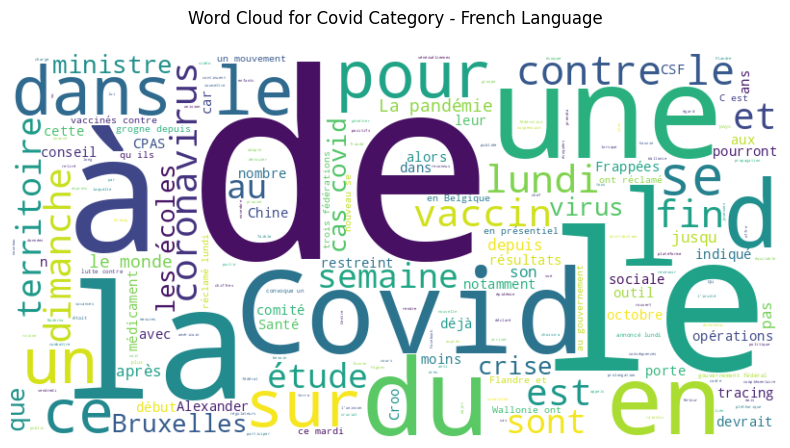

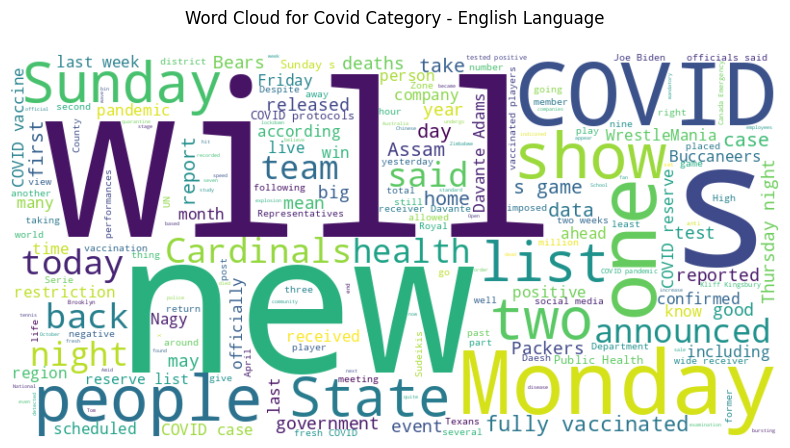

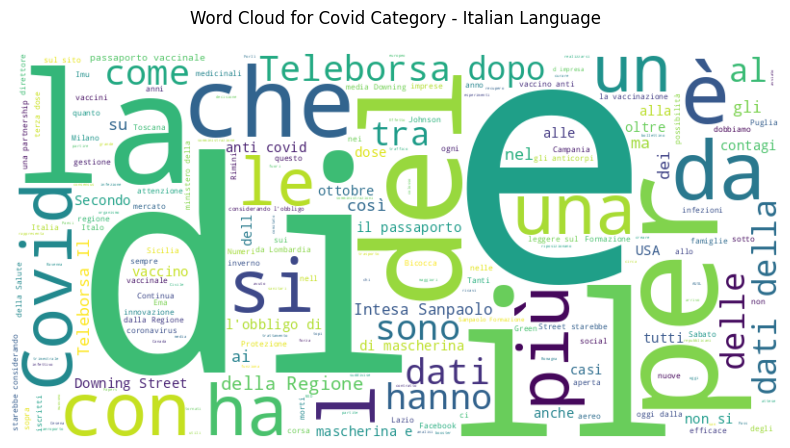

In [32]:

categories = grouped_df['Category'].unique()
languages = grouped_df['language_name'].unique()
plot_wordclouds_by_language(dataframe, categories, languages)

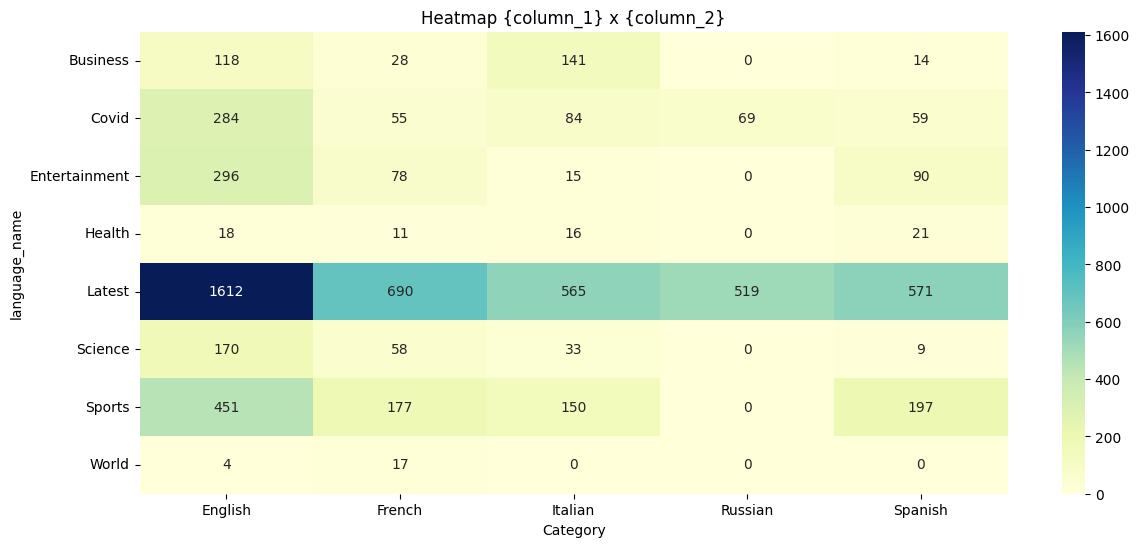

In [33]:
plot_heatmap_by_categories(dataframe, 'Category', 'language_name')

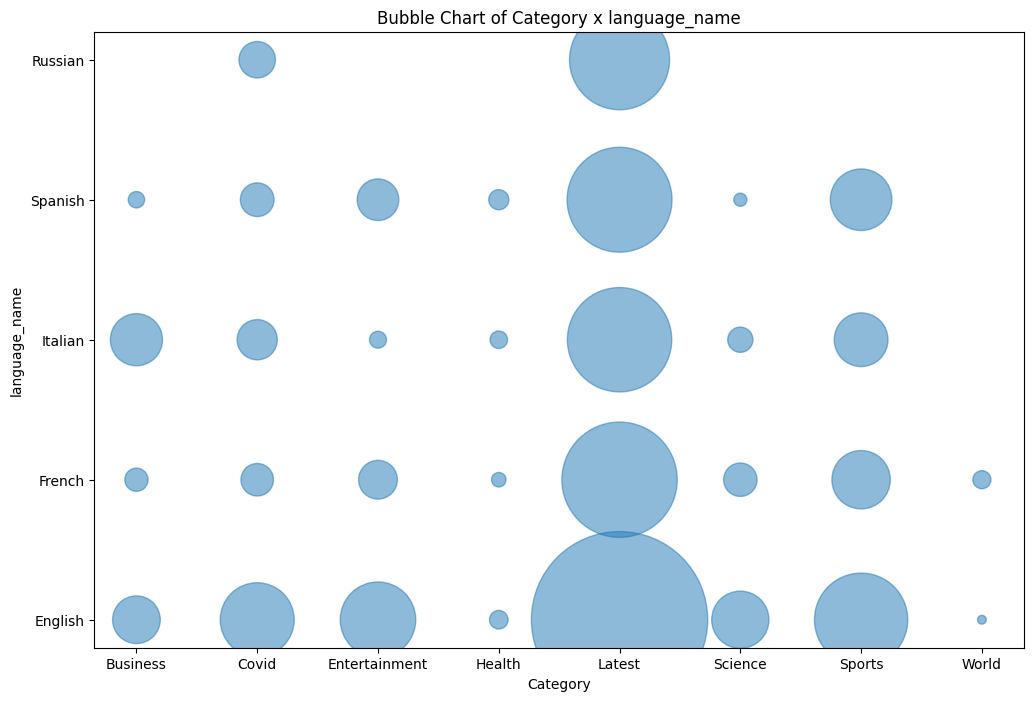

In [34]:
plot_bubble_by_categories(dataframe, 'Category', 'language_name')

## Text Cleaning

In [35]:
stopwords_dict = {}
for language in most_common_language:
    stopwords_dict[language.lower()] = get_stopwords(language)

In [37]:
dataframe['cleaned_description'] = dataframe.progress_apply(lambda x: clean_text(x['description'], 
                                                                          True,
                                                                          stopwords_dict,
                                                                          x['language_name']), axis=1)

dataframe['len_cleaned_description'] = dataframe['cleaned_description'].apply(lambda x: len(x.split(' ')))

100%|██████████| 6620/6620 [00:59<00:00, 110.36it/s]


In [38]:
dataframe['cleaned_full_description'] = dataframe.progress_apply(lambda x: clean_text(x['full_description'], 
                                                                          True,
                                                                          stopwords_dict,
                                                                          x['language_name']), axis=1)

dataframe['len_cleaned_full_description'] = dataframe['cleaned_full_description'].apply(lambda x: len(x.split(' ')))

100%|██████████| 6620/6620 [07:31<00:00, 14.66it/s]


In [42]:
dataframe[['description', 'cleaned_description', 'full_description', 'cleaned_full_description']].sample()

,description,cleaned_description,full_description,cleaned_full_description
21109,"DAL CORRISPONDENTE DA CATANIA. Anche oggi, dop...",corrispondente catania oggi dopo langelus ieri...,"DAL CORRISPONDENTE DA CATANIA. Anche oggi, dop...",corrispondente catania oggi dopo langelus ieri...


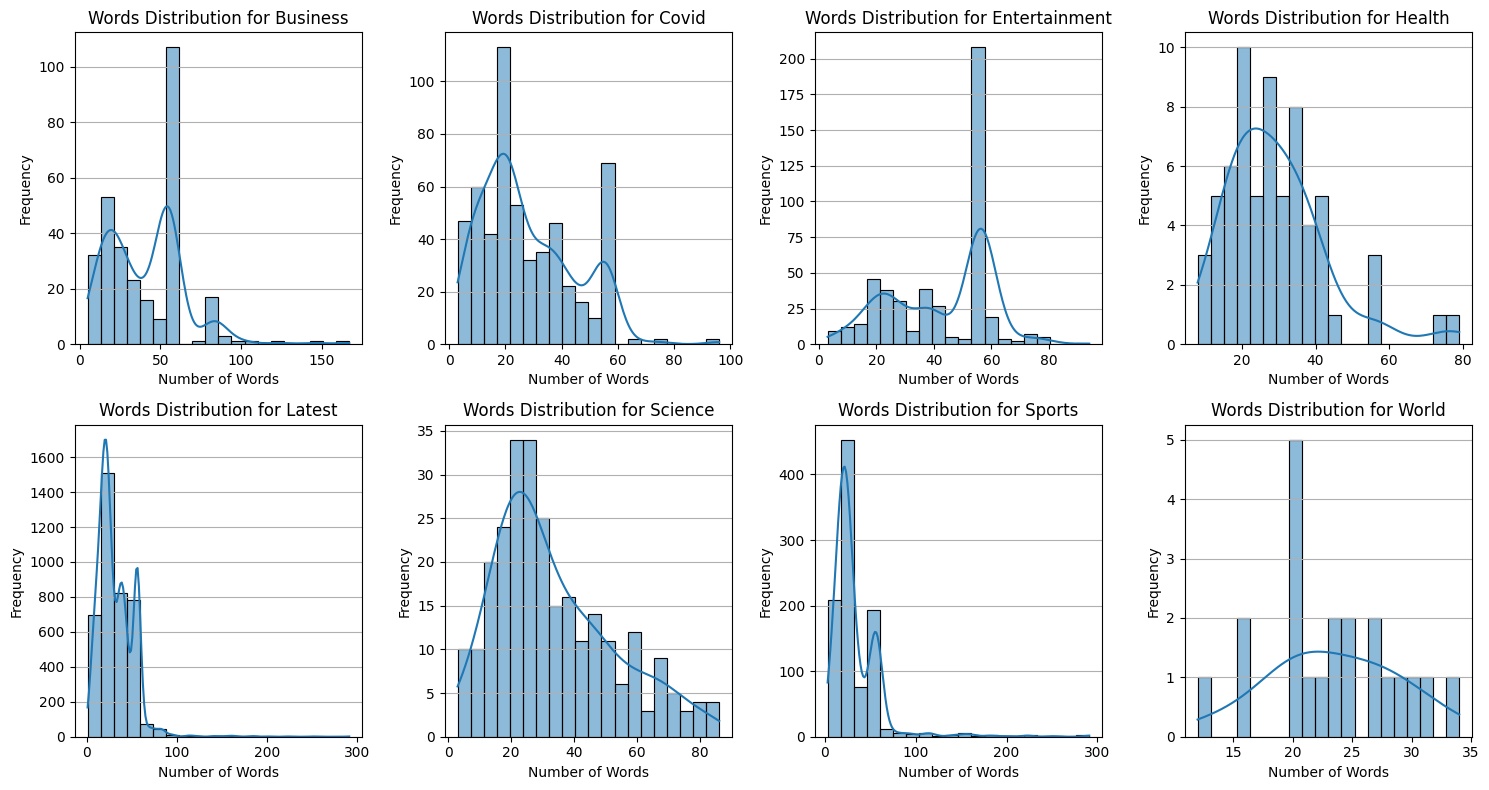

In [40]:
categories = mean_lengths['Category'].unique()
nrows = 2
ncols = 4
plot_subplots(dataframe, nrows, ncols, categories)

#### Save Processed Dataframe

In [45]:
dataframe.to_parquet('../Datasets/pre_processed_dataframe/clean_df.parquet', index=False)